<a href="https://colab.research.google.com/github/sara81278/ADM-HMW3_group25/blob/main/DCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dctn, idctn
import random

### DCT Util Funcions

In [48]:
def my_dctn(image_block):
  'Implementation of two or one-dimentional idctn'
  if(len(np.shape(image_block)) == 1):
    image_block = np.reshape(image_block, (np.shape(image_block)[0], 1))

  M, N = np.shape(image_block)
  B = np.zeros((M, N))
  for p in range(M):
    alpha_p = 1/np.sqrt(M) if p == 0 else np.sqrt(2/M)
    cos_coef_p = np.pi * p /(2*M)
    for q in range(N):

      alpha_q = 1/np.sqrt(N) if q == 0 else np.sqrt(2/N)
      cos_coef_q = np.pi * q /(2*N)

      B_p_q = alpha_p*alpha_q*np.sum(
          [np.sum(
              [image_block[m,n]*np.cos(cos_coef_p*(2*m+1))*np.cos(cos_coef_q*(2*n+1)) for n in range(N)]
              ) for m in range(M)]
          )
      B[p, q] = np.round(B_p_q,8)
  B[p, :] *= alpha_p
  B[:, q] *= alpha_q
  if(np.shape(image_block)[1] == 1):
    B = np.reshape(B, (M,))
  return B

In [49]:
def my_idctn(B):
  'Implementation of one-dimentional idctn'
  N = len(B)
  A_n = np.zeros(N)
  for n in range(N):
    alpha_q = np.concatenate(([np.sqrt(1/N)], np.ones(N-1)*np.sqrt(2/N)))
    cosines = np.cos(np.pi*np.arange(N)/(2*N)*(2*n+1))
    A_n[n]= round(alpha_q*B @ cosines, 8)
  return A_n

def my_idctn_no_alpha(B):
  N_samples = len(B)
  'Implementation of one-dimentional idctn'
  A_n = np.zeros(N_samples)
  for n in range(N_samples):
    cosines = np.cos(np.pi*np.arange(N_samples)/(2*N_samples)*(2*n+1))
    A_n[n]= round(B @ cosines, 8)
  return A_n

In [50]:
def function_eval(x, function='sin', f_mod=0.25):
  """
  This function evaluates a vector for a given function.

  Parameters
  ----------
  x : ndarray
      Input array.
  function : string
      Name of the function to be computed. Choose among:
        - linear: y(x) = x
        - sine: y(x) = sin(pi*x/2)
        - compander: y(x) =
        - square: y(x) = sign(x) * x**2
        - sqrt: y(x) = sign(x) * sqrt(abs(x))

  Returns
  -------
  y : ndarray
      The function values.
  """
  N = len(x)
  #x_s = x[:int(N/2)]
  if function == 'linear':
      y = f_mod * ( x - (N-1)/2 - 1 )
  elif function == 'sin':
      y = (f_mod*N/2) * ( np.sin( np.pi*x/N - np.pi/2 ) - 0.5*2/N ) #
      #y = np.hstack(( y_b, np.flip(-y_b) ))
  elif function == 'sigmoid':
      mu = -0.5 * N/2
      y_left = (f_mod*N/2) * ( 1 - np.exp( -(f_mod/mu)*x[:int(N/2)] )) / ( 1 - np.exp( -f_mod*N/(2*mu) ))
      y_right = np.flip(-y_left) + f_mod*N
      y = np.hstack(( y_left, y_right )) - f_mod*N/2
  elif function == 'square':
      y_right = f_mod**2/(2*np.sqrt(N)) * x[:int(N/2)]**2
      y = np.hstack(( np.flip(-y_right), y_right ))
  elif function == 'sqrt':
      y_right = N/8 * np.sqrt( x[:int(N/2)]/x[int(N/2)] )
      y_left = -np.flip(y_right)
      y = np.hstack(( y_left, y_right ))
  #TBD
  elif function == 'poly':
      y = 0.01*x**4 + 0.1*x**3 - 0.02*x**2
  elif function == 'exp':
      y = np.exp(x)
  elif function == '-exp':
      y = -np.exp(x)
  elif function == 'floor':
      y = np.floor(x)
  elif function == 'abs':
      y = np.abs(x)
  elif function == 'sign':
      y = np.sign(x)
  else:
      print("Function not available. Sine function assumed.")
      y = np.sin(x)
  return y

ALL_COEFFS = 256

def function_select(function='sin', N=ALL_COEFFS, f_mod=1):
  """
  This function creates a the function values for a given interval and number
  of samples.

  Parameters
  ----------
  function : string
      Name of the function to be computed.
  N : int
      The number of samples.
  f_mod : int or real
      Spreading factor of the chirp signal

  Returns
  -------
  x : ndarray
      The interval of x values.
  y : ndarray
      The function values.

  """
  x = np.arange(1, N+1)
  y = function_eval(x, function, f_mod)
  return x, y


In [51]:
def compact_coefficients_number(B, energy_percentage = 0.9997):
  'This function computes the minimum number of coefficient we need to retain at least energy_percentage% of the total energy'
  total_energy = np.sqrt(np.sum(B**2))
  for i in range(0, len(B)):
    energy = np.sqrt(np.sum(B[:i+1]**2))
    if(energy >= energy_percentage*total_energy):
      return i+1

In [52]:
coefficients = my_dctn(np.arange(8))

compact_coefficients_number(coefficients, 0.999)

4

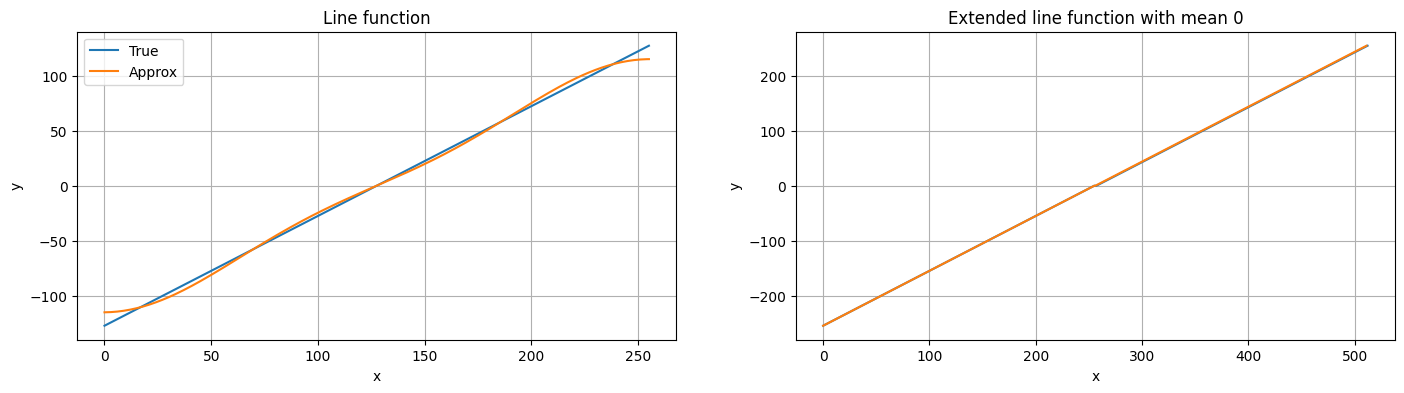

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(17,4))
N=256
x = np.arange(0, N)
y = x-np.mean(x)

dct_coeff = dctn(y, type = 2, norm = 'ortho')
dct_coeff[4:] = 0

ax[0].plot(x,y, label ='True')
ax[0].plot(my_idctn(dct_coeff), label='Approx')
ax[0].set(xlabel = "x", ylabel = "y", title = "Line function")
ax[0].legend()
ax[0].grid(True)

y_extended = np.concatenate((np.flip(-x),x))
x_extended = np.concatenate((x,np.arange(257, 513)))
dct_coeff_extended = dctn(y_extended, type = 2, norm = 'ortho')


ax[1].plot(x_extended, y_extended)
ax[1].set(xlabel = "x", ylabel = "y", title = "Extended line function with mean 0")
ax[1].plot(my_idctn(dct_coeff_extended))
ax[1].grid(True)

plt.show()

In [54]:
def MSE_pratico(f, f_hat):
  'Mean Squared difference between the true function and its approximation'
  return np.mean((f-f_hat)**2)

def NMSE_pratico(f, f_hat):
  'Normalized Mean Squared difference between the true function and its approximation'
  return MSE_pratico(f, f_hat)/np.mean(f**2)

def MSE_teorico(dct_coeff, Q):
  'Mean Squared Error that is obtained when we retain only Q dct coefficients'
  return np.mean(dct_coeff[Q:]**2)

def NMSE_teorico(f, dct_coeff, Q):
  'Normalized MSE that is obtained when we retain only Q dct coefficients'
  return MSE_teorico(dct_coeff, Q)/np.mean(f**2)

def MSE_energy_percentage(dct_coeff, alpha):
  ''' Mean Squared Error that is obtained when we retain alpha% of the total energy'''
  total_energy = np.sqrt(np.sum(dct_coeff**2))
  return (1-alpha)/len(dct_coeff)*total_energy

def NMSE_energy_percentage(f, dct_coeff, alpha):
  ''' Normalized Mean Squared Error that is obtained when we retain alpha% of the total energy'''
  return MSE_energy_percentage(dct_coeff, alpha)/np.mean(f**2)

In [83]:
def odd_sqrt(x):
  'Computes the odd square root, with mean 0'
  N = max(x)
  N_samples = len(x)
  y_sqrt = np.zeros(N_samples)

  for i in range(N_samples):
    if x[i]> N/2:
      y_sqrt[i] = (N/2)*np.sqrt(2*(x[i]-N/2)/N)
    else:
      y_sqrt[i] = -(N/2)*np.sqrt(-2*(x[i]-N/2)/N)
  return y_sqrt

def odd_sin(x):
  'Computes the odd sin function, with mean 0'
  N = max(x)
  y_sin = N/2 * np.sin(np.pi * (x-N/2)/N)
  y_sin -= np.mean(y_sin)
  return y_sin

def cosine(x):
  N = max(x)
  y_cosine = np.cos(np.pi * (x/N- 1/2)) *(N/2)
  y_cosine -= np.mean(y_cosine)
  return y_cosine

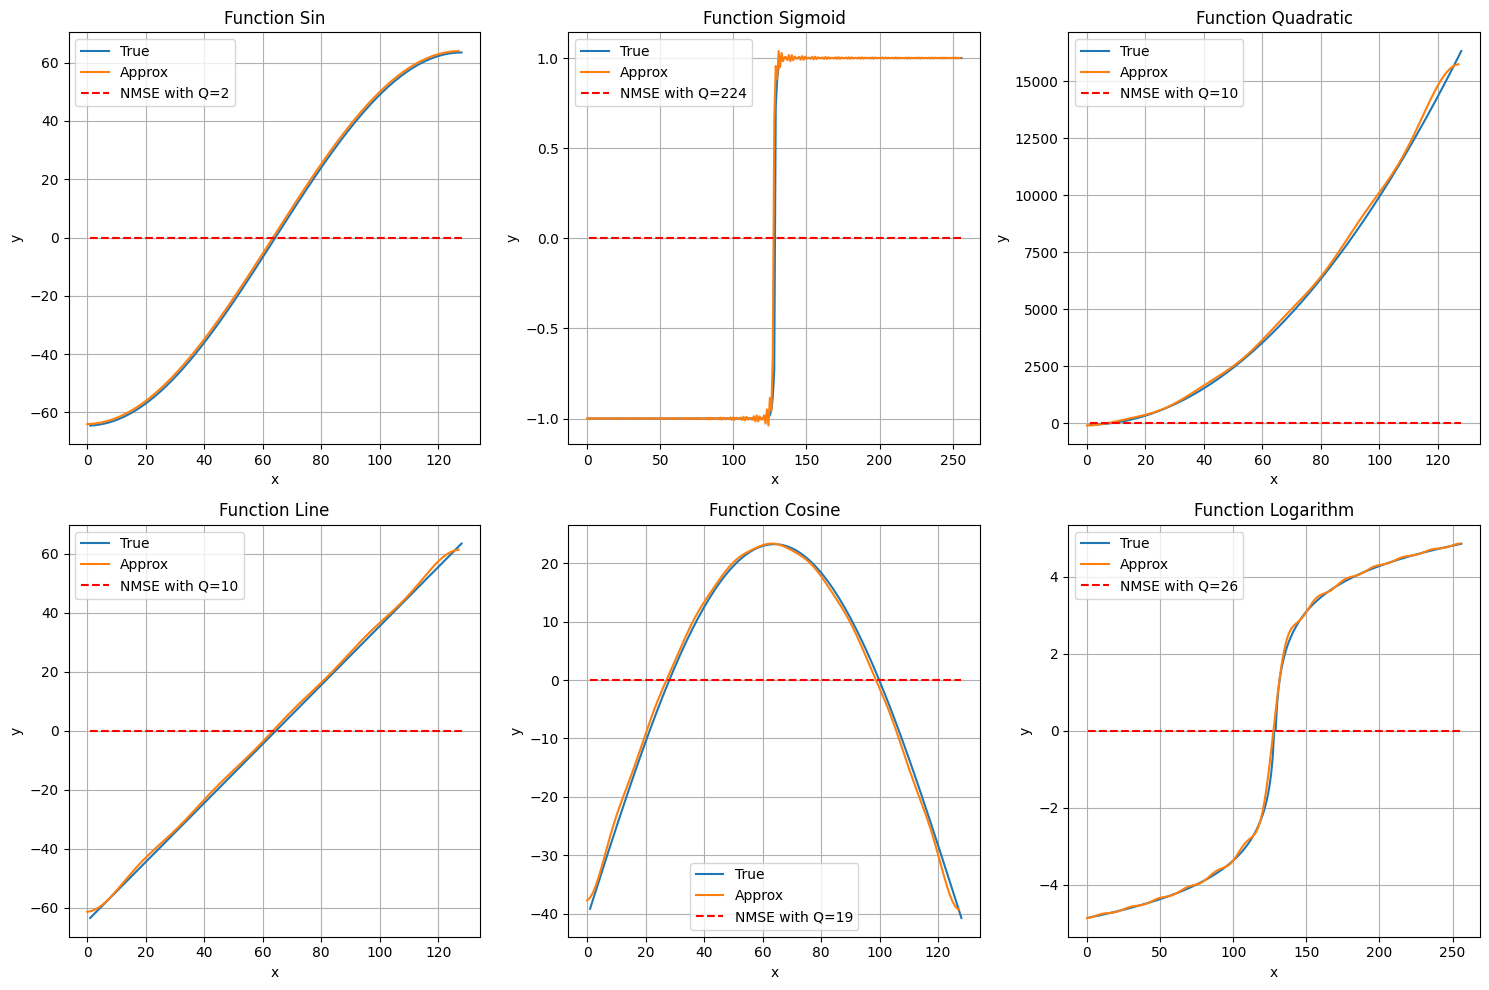

In [84]:
# Create 3x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

functions = [odd_sin, lambda z:1/(1 + np.exp(-z)), lambda x: np.square(x)-np.mean(x), lambda x:x-np.mean(x), cosine, np.log]
function_names = ['Sin', 'Sigmoid', 'Quadratic', 'Line', 'Cosine', 'Logarithm']
N=128

energy_to_retain = 0.9999

for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        func_index = i * 3 + j  # Calculate the function index
        if func_index < len(functions):

          #True function
          x = np.arange(1, 129)
          y = functions[func_index](x)
          if(function_names[func_index] in ['Logarithm', 'Sigmoid']):
            y = np.concatenate((np.flip(-y), y))
            x = np.concatenate((x,np.arange(129, 257)))

          ax.plot(x, y, label='True')

          #Approximation
          dctn_coefficients = dctn(y, type = 2, norm = 'ortho')
          Q = compact_coefficients_number(dctn_coefficients, energy_to_retain)
          dctn_coefficients[Q:] = 0
          y_hat = idctn(dctn_coefficients, type = 2, norm = 'ortho')
          ax.plot(y_hat, label='Approx')

          #NMSE lines
          mse = NMSE_pratico(y, y_hat)
          ax.plot(x, np.ones(len(x))*mse, label=f'NMSE with Q={Q}', linestyle='--', color='red')
          ax.set(xlabel = "x", ylabel = "y", title = f"Function {function_names[func_index]}")
          ax.legend()
          ax.grid(True)
        else:
          ax.set_title(f"Function {function_names[func_index]}")
        ax.grid(True)

plt.tight_layout()
plt.show()

### LMSE

In [73]:
def LMSE(x_batch, y_true, N, Q, B_p_hat, alpha = 0.01, max_iterations= 40000, true_function = odd_sqrt):
  '''Least Mean Squared Error
    x_batch = batch
    y_true = f(x_batch)
    N = function domain
    Q = number of coefficients to retain
    B_p_hat = starting coefficients
    alpha = percentage of error we allow
    max_iterations = maximum number of iterations, by default 40k
    true_function = function to approximate, needed to compute the theoretical MSE_min and misadjustment
  '''

  mu=4*alpha/Q

  N_samples = len(x_batch)
  B_p_hat[2*Q:] = 0

  mse_history = []
  B_hat_history = []

  # For each point i, compute the error at point i using Q coefficients and then update the coefficients
  for i in range(N_samples):
    #Compute the error at point i
    y_hat = 0
    for q in range(Q):
      cosine_coefficient = np.pi*(2*q+1)/(2*N)
      x_n = np.cos(cosine_coefficient*(2*x_batch[i]+1))
      idct_i = B_p_hat[2*q+1]*x_n
      y_hat += idct_i

    error_i = y_true[i]- y_hat
    mse_history.append(error_i**2)

    #Update the coefficients
    for q in range(Q):
      B_p_hat[2*q+1] += mu*error_i*np.cos(np.pi*(2*q+1)/(2*N)*(2*x_batch[i]+1))

    B_hat_history.append(B_p_hat)

  convergency_rate = -np.log(alpha)*Q/(2*alpha) ## After how many samples we converge
  if(N_samples > convergency_rate):
    print(f'Convergency rate: {np.ceil(convergency_rate)} samples')
    error_misured = np.mean(mse_history[int(convergency_rate)+1: ]) # MSE at convergence
    error_misured = np.round(error_misured, 4)
    print(f'Error misured: {error_misured}')

    mse_min = MSE_teorico(dctn(true_function(np.arange(N)), type=2, norm='ortho'), 2*Q)
    mse_min = np.round(mse_min, 4)

    print(f'Misadjustment: {np.round( 100*np.abs(error_misured-mse_min)/(2*mse_min), 4)}%, mse minimo {mse_min}')

  if(N_samples < convergency_rate):
    print('Sample size too small to reach desired convergence')
  return (B_p_hat, mse_history)

In [78]:
N = 128
N_samples = 10000
#Creating the dataset
x = np.random.randint(0,N,N_samples)
alpha = np.concatenate(([1],np.sqrt(2)*np.ones(len(x)-1)))/np.sqrt(len(x))
# Starting point
y_linear = x-np.mean(x)
dctn_linear = dctn(y_linear, type = 2, norm = 'ortho')*alpha

#### Approximating Sin function with LMSE

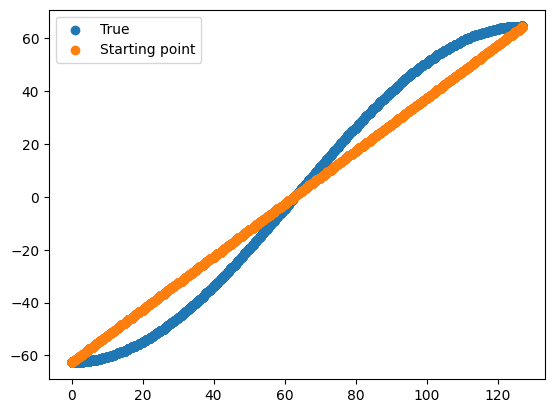

In [79]:
#Function to approximate
y_sin = odd_sin(x)

plt.scatter(x, y_sin, label = 'True')
plt.scatter(x, my_idctn_no_alpha(dctn_linear), label ='Starting point')
plt.legend()
plt.show()

Convergency rate: 1382.0 samples
Error misured: 0.1193
Misadjustment: 119200.0%, mse minimo 0.0001


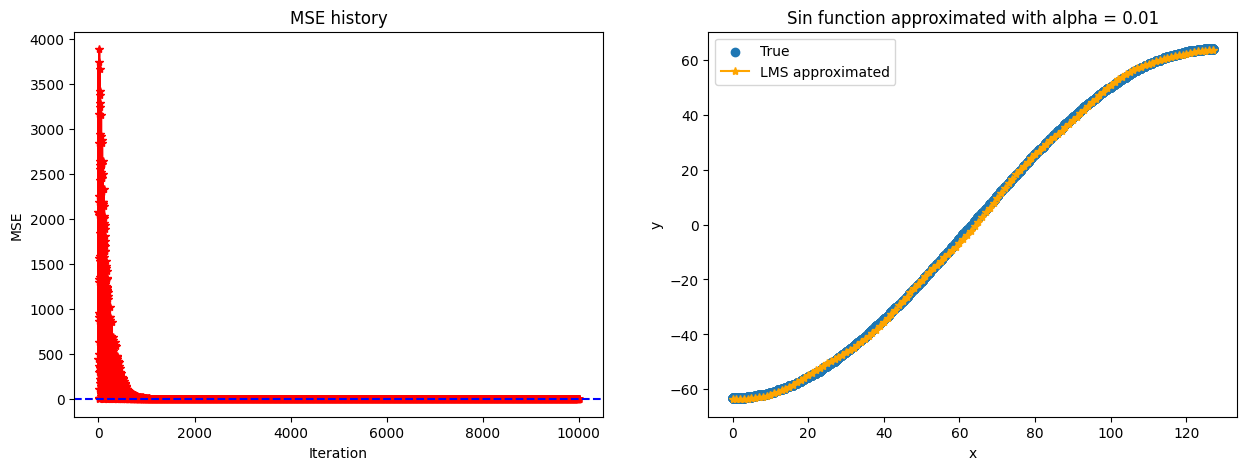

In [74]:
Q = 6
alpha = 0.01
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sin, N, Q, B_p_hat, alpha = alpha, true_function = odd_sin) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=alpha, color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sin, label ='True')
axes[1].plot(my_idctn_no_alpha(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sin function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()

Sample size too small to reach desired convergence


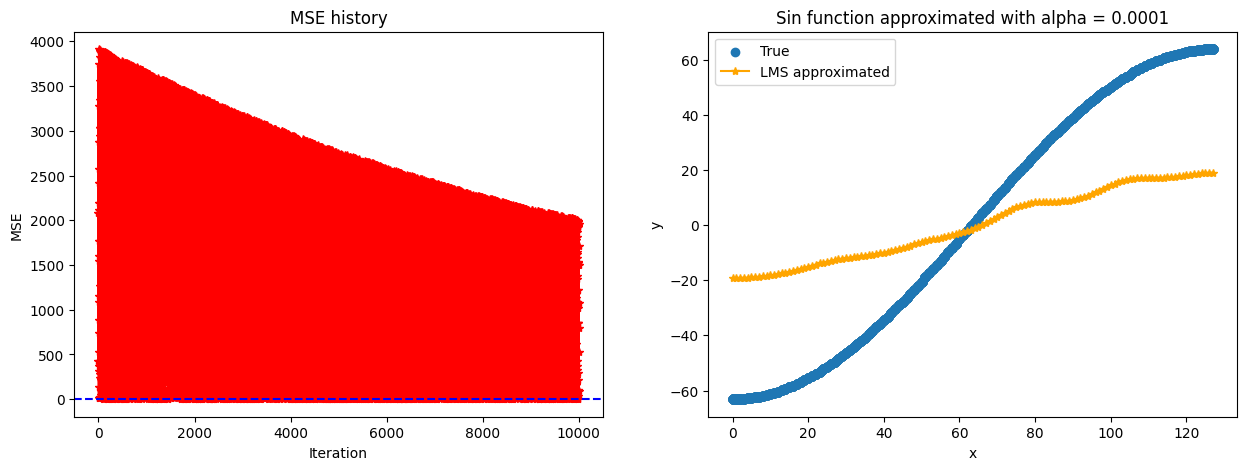

In [75]:
Q = 6
alpha = 0.0001
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sin, N, Q, B_p_hat, alpha = alpha, true_function = odd_sin) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=alpha, color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sin, label ='True')
axes[1].plot(my_idctn_no_alpha(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sin function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()

#### Approximating sqrt function with LMSE

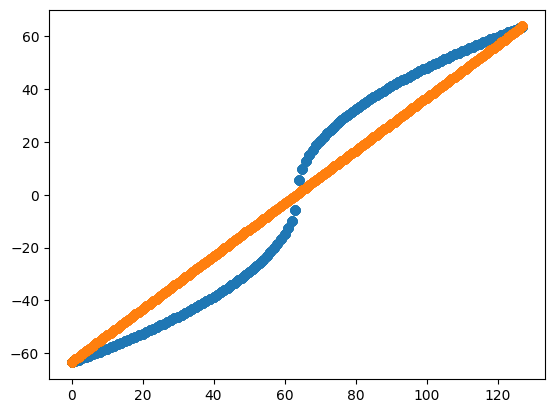

In [76]:
y_sqrt = odd_sqrt(x)
plt.scatter(x,y_sqrt)
plt.scatter(x, my_idctn_no_alpha(dctn_linear), label ='Starting point')

Convergency rate: 1382.0 samples
Error misured: 1.5049
Misadjustment: 12.6328%, mse minimo 1.7225


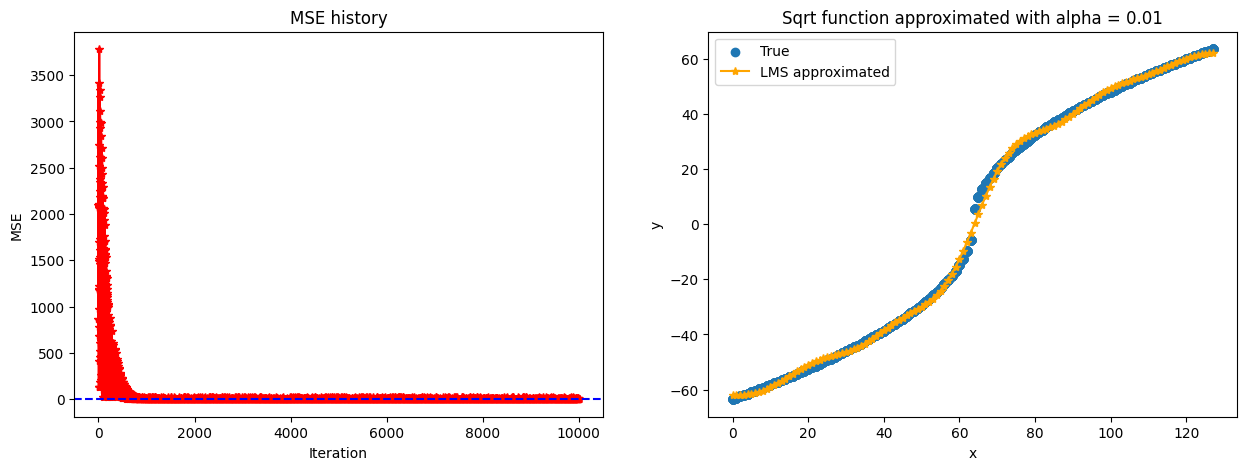

In [77]:
Q = 6
alpha = 0.01
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sqrt, N, Q, B_p_hat, alpha = alpha, true_function = odd_sqrt) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=MSE_teorico(dctn(odd_sqrt(np.arange(128)), type = 2, norm = 'ortho'), Q=12), color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sqrt, label ='True')
axes[1].plot(my_idctn_no_alpha(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sqrt function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()

Sample size too small to reach desired convergence


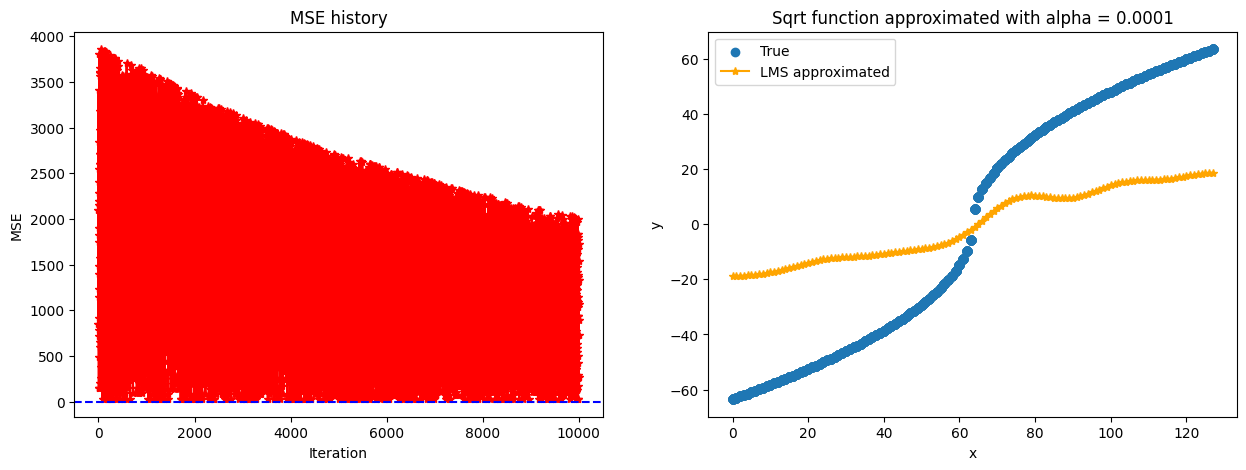

In [68]:
Q = 6
alpha = 0.0001
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sqrt, N, Q, B_p_hat, alpha = alpha, true_function = odd_sqrt) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=alpha, color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sqrt, label ='True')
axes[1].plot(my_idctn_no_alpha(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sqrt function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()